In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import glob

In [2]:
df = pd.read_csv('../datasets/weather_station/weather.csv.zip')

In [3]:
df

,date_sensor_read,rain,sky_temperature,ambient_temperature
0,2019-04-08 00:00:11,False,-3.23,8.31
1,2019-04-08 00:01:12,False,-4.01,8.33
2,2019-04-08 00:02:13,False,-3.91,8.37
3,2019-04-08 00:03:00,False,-2.87,8.43
4,2019-04-08 00:03:26,False,-1.79,8.39
...,...,...,...,...
829732,2020-04-05 17:21:27,True,10.57,12.01
829733,2020-04-05 17:22:28,True,10.95,12.01
829734,2020-04-05 17:22:47,True,9.67,11.97
829735,2020-04-05 17:23:44,True,10.75,12.07


In [4]:
files = [f for f in glob.glob("../datasets/sky_quality_meter/SQM_DL/*.dat", recursive=True)]

shards=[]
for f in files:
    df = pd.read_csv(f, comment='#', delimiter=';', names=['UTCDateTime', 'LocalDateTime', 'Temperature', 'Voltage', 'MSAS', 'Recordtype'], parse_dates=['UTCDateTime', 'LocalDateTime'])
    shards.append(df)
    
sqm_data = pd.concat(shards)

In [5]:
sqm_data

,UTCDateTime,LocalDateTime,Temperature,Voltage,MSAS,Recordtype
0,2019-05-26 21:00:05,2019-05-26 22:00:05,9.9,5.0,10.01,1
1,2019-05-26 21:05:05,2019-05-26 22:05:05,9.9,5.0,10.74,1
2,2019-05-26 21:10:05,2019-05-26 22:10:05,9.6,5.0,11.39,1
3,2019-05-26 21:15:05,2019-05-26 22:15:05,9.6,5.0,12.07,1
4,2019-05-26 21:20:05,2019-05-26 22:20:05,9.3,5.0,12.76,1
...,...,...,...,...,...,...
104,2019-04-22 04:40:05,2019-04-22 05:40:05,4.8,5.0,13.89,1
105,2019-04-22 04:45:05,2019-04-22 05:45:05,4.8,5.0,12.99,1
106,2019-04-22 04:50:05,2019-04-22 05:50:05,4.8,5.0,12.11,1
107,2019-04-22 04:55:05,2019-04-22 05:55:05,4.5,5.0,11.24,1


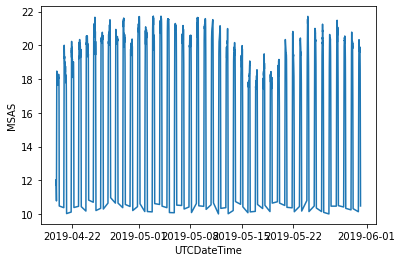

In [6]:
sns.lineplot(x="UTCDateTime", y="MSAS",
             data=sqm_data)

In [7]:
from astropy.utils import iers
iers.IERS_A_URL = 'ftp://cddis.gsfc.nasa.gov/pub/products/iers/finals2000A.all'
from astroplan import download_IERS_A
download_IERS_A()

In [8]:

import multiprocessing as mp
from astropy.coordinates import EarthLocation
from astroplan import Observer
import astropy.units as u

def sunalt(datetime):
    lat=52.2533
    lon=-8.3605
    elev=80
    location = EarthLocation.from_geodetic(lon*u.deg, lat*u.deg, elev*u.m)
    observer = Observer(location=location)
    return observer.sun_altaz(datetime).alt.deg

def moonalt(datetime):
    lat=52.2533
    lon=-8.3605
    elev=80
    location = EarthLocation.from_geodetic(lon*u.deg, lat*u.deg, elev*u.m)
    observer = Observer(location=location)
    return observer.moon_altaz(datetime).alt.deg

def moonill(datetime):
    lat=52.2533
    lon=-8.3605
    elev=80
    location = EarthLocation.from_geodetic(lon*u.deg, lat*u.deg, elev*u.m)
    observer = Observer(location=location)
    return observer.moon_illumination(datetime)


pool = mp.Pool(mp.cpu_count())

sqm_data['sun_alt'] = pool.map(sunalt, [dt for dt in sqm_data['UTCDateTime'].values])
sqm_data['moon_alt'] = pool.map(moonalt, [dt for dt in sqm_data['UTCDateTime'].values])
sqm_data['moon_illumination'] = pool.map(moonill, [dt for dt in sqm_data['UTCDateTime'].values])
pool.close()
# sqm_data['sun_alt'] = sunalt(sqm_data['UTCDateTime'])

In [14]:
derek_dark = sqm_data[(sqm_data['sun_alt']<-18) & (sqm_data['moon_alt']<-12)]

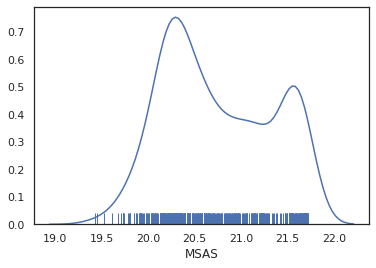

In [16]:
sns.set(style="white")
sns.distplot(derek_dark['MSAS'], hist=False, rug=True, color="b")